# 0 : Data Import & Quick Look

In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
import matlab.engine 
import mat73
import math

In [2]:
data = mat73.loadmat('data_wS1_wM1_wS2_wM2_Exp.mat')

In [3]:
for key, value in data['data'].items() :
    print (key)

AP
ARAindex
BehResults
CRIndices
CompletedTrialIndices
FAIndices
HitIndices
Jaw_pos
Jaw_sp
LickData
LickOnsets
LickTime
LightIndices
MDS
ML
MissIndices
ReactionTimes
ReactionTimes_All
StimIndices_All
Tongue_pos
Tongue_sp
TrialOnsets_All
TrialOnsets_Compeleted
ValveOnsets
Whisker_pos
Whisker_sp
XYZ32
area
cluster
date
depth
expert
include
mouse
row
safe_name
session
spikets
struct
struct_acr
width


In [4]:
len(data['data']['area'][10])

80

In [5]:
#width is time from trough to baseline
data['data']['width'][0]

array([0.49303333, 0.34236667, 0.2006    , 0.18213333, 0.36073333,
       0.2434    , 0.42223333, 0.45196667, 0.14926667, 0.4172    ,
       0.21323333, 0.3598    , 0.13023333, 0.4587    , 0.39233333,
       0.27526667, 0.60313333, 0.5184    , 0.22983333, 0.20526667,
       0.40316667, 0.4857    , 0.19633333, 0.4044    , 0.13953333,
       0.17313333, 0.39926667, 0.24086667, 0.39693333, 0.1508    ,
       0.56476667, 0.35156667, 0.48893333, 0.22343333, 0.21606667,
       0.5885    , 0.5506    , 0.58133333, 0.234     , 0.32756667,
       0.20103333, 0.25106667, 0.4847    , 0.261     , 0.7242    ,
       0.48693333, 0.38583333, 0.4776    , 0.22286667, 0.554     ,
       0.3902    , 0.2361    , 0.78056667, 0.46406667, 0.60036667,
       0.73833333])

In [6]:
sessAreas = {}
for MDS, areas in zip(data['data']['MDS'],data['data']['area']):
    print(MDS)
    sessAreas[str(MDS)] = set(areas)

13.0
65.0
24.0
47.0
58.0
1.0
18.0
19.0
45.0
73.0
72.0


In [7]:
sessAreas

{'13.0': {'wM1', 'wS1'},
 '65.0': {'wM1', 'wS1'},
 '24.0': {'wM2', 'wS2'},
 '47.0': {'wM2', 'wS2'},
 '58.0': {'wM2', 'wS2'},
 '1.0': {'wM2', 'wS1'},
 '18.0': {'wM2', 'wS1'},
 '19.0': {'wM2', 'wS1'},
 '45.0': {'wM2', 'wS1'},
 '73.0': {'wM2', 'wS1'},
 '72.0': {'wM1', 'wS2'}}

In [8]:
def areaLooker(area):
    return [key  for (key, value) in sessAreas.items() if area in value]

In [9]:
def areaPairLooker(areas):
    return [key  for (key, value) in sessAreas.items() if areas[0] in value and areas[1] in value]

In [10]:
areaPairLooker(('wM1','wS1'))

['13.0', '65.0']

In [11]:
knownPairs = tuple((('wM1','wS1'),('wM2','wS2'),('wM2','wS1'),('wM1','wS2')))

In [12]:
pairMDSs = {}
for pair in knownPairs:
    pairMDSs[pair] = areaPairLooker(pair)

In [13]:
pairMDSs

{('wM1', 'wS1'): ['13.0', '65.0'],
 ('wM2', 'wS2'): ['24.0', '47.0', '58.0'],
 ('wM2', 'wS1'): ['1.0', '18.0', '19.0', '45.0', '73.0'],
 ('wM1', 'wS2'): ['72.0']}

In [14]:
MDSs = data['data']['MDS']

# 1 : Data visualization

## 1.1 Raster plots

### Raster plot functions

In [15]:
def rasterPlotArrays (trials, spikets, timeBefore, timeAfter):
    raster = []
    rowLength = (timeBefore+timeAfter)
    
    for (i,trial) in enumerate(trials):
        rasterRow = []
        
        #selecting spikes around the trial time
        spikesInCurrentTrial = [spike for spike in spikets if (spike > trial - timeBefore) and (spike < trial + timeAfter)]
        
        #subtracting spike times with current trial so spikes begin at 0ms & end at timeBefore+timeAfter
        spikesInCurrentTrial = np.subtract(spikesInCurrentTrial,trial)
        
        for spike in spikesInCurrentTrial:
            
            rasterRow.append(spike)
        
        raster.append(rasterRow)
    return raster

In [16]:
def makeTrialTypesArray(session):
    trials = data['data']['TrialOnsets_All'][session]
    CRIndices = data['data']['CRIndices'][session]
    trialsCR = trials[CRIndices]
    MissIndices = data['data']['MissIndices'][session]
    trialsMiss = trials[MissIndices]
    FAIndices = data['data']['FAIndices'][session]
    trialsFA = trials[FAIndices]
    HitIndices = data['data']['HitIndices'][session]
    trialsHit = trials[HitIndices]
    
    trialTypes = []
    for trial in trials:
        if trial in trialsHit:
            trialTypes.append('Hit')
        elif trial in trialsMiss:
            trialTypes.append('Miss')
        elif trial in trialsCR:
            trialTypes.append('CR')
        elif trial in trialsFA:
            trialTypes.append('FA')
        else:
            trialTypes.append('EarlyLick')
    return trialTypes

### Raster plot for one trial type (Fig. 1)

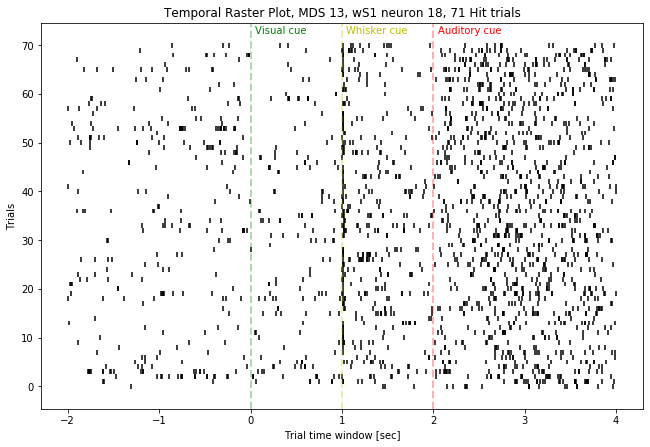

In [17]:
sess = 0
MDS = data['data']['MDS'][sess]
neuron = 18
timeBefore = 2.
timeAfter = 4.

neuronType = data['data']['area'][sess][neuron]
trials = data['data']['TrialOnsets_All'][sess] #for x-th session
HitIndices = data['data']['HitIndices'][sess]
trialType = 'Hit'
spikes = data['data']['spikets'][sess][neuron] #for x-th session & y-th neuron
trialsHit = trials[HitIndices]
#rasterPlotterType(trialsHit,spikes, sess, neuron, neuronType, trialType)

numTrials = len(trialsHit)
f = plt.figure(figsize = (1.8 * (timeBefore + timeAfter),numTrials * .1 ))
ax = f.add_subplot(111)
ax.eventplot(rasterPlotArrays(trialsHit, spikes, timeBefore, timeAfter), colors = 'black')

#Visual cue/Trial start
ax.axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
ax.text(x = .05, y = 1.02 * numTrials , s = "Visual cue", color = 'green')

#Whisker cue
ax.axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
ax.text(x = 1.05, y = 1.02 * numTrials, s = "Whisker cue", color = 'y')

#Auditory cue
ax.axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
ax.text(x = 2.05, y = 1.02 * numTrials, s = "Auditory cue", color = 'red')


titletext = 'Temporal Raster Plot, MDS ' + str(int(MDS)) + ', ' + neuronType + ' neuron ' + str(neuron) + ', ' + str(numTrials) + ' ' + trialType + ' trials'
filetext = 'Figures/1 Temporal Raster Plot for specific trial type/' + str(int(MDS)) + ' - Temporal Raster Plot, ' + neuronType + ' neuron ' + str(neuron) + ', ' + str(numTrials) + ' ' + trialType + ' trials' + '.jpeg'
ax.set_title(titletext)
ax.set_xlabel('Trial time window [sec]')
ax.set_ylabel('Trials')

plt.savefig(filetext, format = 'jpeg')
#plt.tight_layout()
plt.show()

### Raster plot for all trials (Fig. 2)

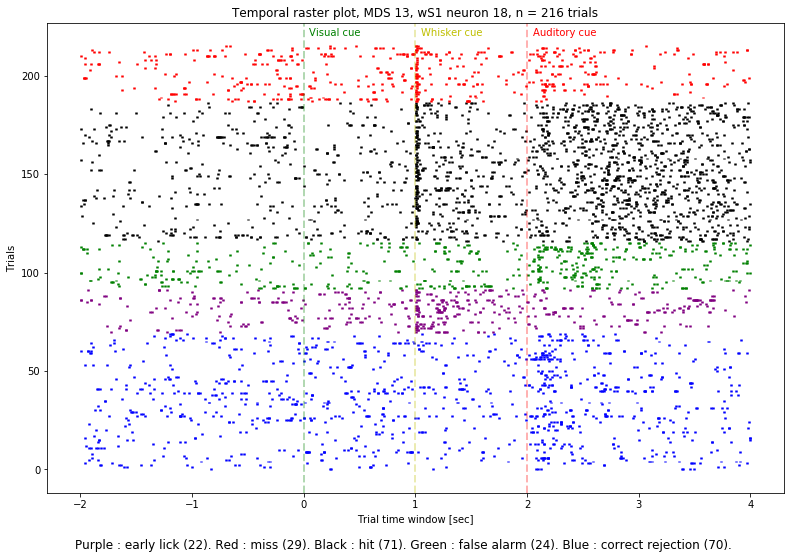

In [18]:
sess = 0
MDS = data['data']['MDS'][sess]
timeBefore = 2.
timeAfter = 4.
neuron = 18 #56 neurons in total (0-55)
neuronType = data['data']['area'][sess][neuron]

CRIndices = data['data']['CRIndices'][sess]
MissIndices = data['data']['MissIndices'][sess]
FAIndices = data['data']['FAIndices'][sess]
HitIndices = data['data']['HitIndices'][sess]

trials = data['data']['TrialOnsets_All'][sess] #for x-th session (194 elements in 0th)

trialsMiss = trials[MissIndices]
trialsHit = trials[HitIndices]
trialsFA = trials[FAIndices]
trialsCR = trials[CRIndices]

spikes = data['data']['spikets'][sess][neuron] #for x-th session & y-th neuron

numTrials = len(trials)
numTrialsHit = len(trialsHit)
numTrialsMiss = len(trialsMiss)
numTrialsFA = len(trialsFA)
numTrialsCR = len(trialsCR)
numTrialsEL = numTrials - numTrialsHit - numTrialsMiss - numTrialsFA - numTrialsCR

f = plt.figure(figsize = (2.2 * (timeBefore + timeAfter),numTrials * .04 ))
ax = f.add_subplot(111)
colors = ['black' if trial in trials[HitIndices] else 'red' if trial in trials[MissIndices] else 'green' 
          if trial in trials[FAIndices] else 'blue' if trial in trials[CRIndices] else 'purple' for trial in trials]
rasterArray = rasterPlotArrays(trials, spikes, timeBefore, timeAfter)
trialTypes = makeTrialTypesArray(sess)
zipped = zip(rasterArray,trialTypes, colors)
res = sorted(zipped, key = lambda x: x[1])
rasterArray = [i[0] for i in res]
colors = [i[2] for i in res]
ax.eventplot(rasterArray, colors = colors, linewidths = 2.5)

#Visual cue/Trial start
ax.axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
ax.text(x = .05, y = 1.02 * numTrials , s = "Visual cue", color = 'green')

#Whisker cue
ax.axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
ax.text(x = 1.05, y = 1.02 * numTrials, s = "Whisker cue", color = 'y')

#Auditory cue
ax.axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
ax.text(x = 2.05, y = 1.02 * numTrials, s = "Auditory cue", color = 'red')

ax.set_title('Temporal raster plot, MDS ' + str(int(MDS)) + ', ' + neuronType + ' neuron ' + str(neuron)
           + ', n = ' + str(numTrials) + ' trials')
ax.set_xlabel('Trial time window [sec]')
ax.set_ylabel('Trials')

plt.suptitle('Purple : early lick (' + str(numTrialsEL) + '). Red : miss (' + str(numTrialsMiss) + 
             '). Black : hit (' + str(numTrialsHit) + '). Green : false alarm (' + str(numTrialsFA) +
             '). Blue : correct rejection (' + str(numTrialsCR) + ').',
             va = 'bottom', y = 0.03)
title = 'Temporal Raster plot, ' + neuronType + ' neuron' + str(neuron)
plt.savefig('Figures/2 Temporal Raster plot for all trials/' + str(int(MDS)) + ' - ' + title + '.jpeg', format = 'jpeg')
plt.show()

## 1.2 PSTH 

### PSTH functions

In [19]:
#Peristimulus Time Histogram computing function
def psthSpikeCount(spikes, trialOnset, timeBefore, timeAfter, binSize):
    #INPUT
    #spikes : array of spike timestamps in sec
    #trialOnset : array of trial onsets in sec
    #timeBefore : time before a trial in sec
    #timeAfter : time after a trial in sec
    #binSize : size of a bin, default : 500ms
    
    #OUTPUT
    #averagedBins : array of bins averaged over all trials (size in sec)
    #stdBins : array of std of those averaged bins (same size as averagedBins)
    #binCenters : array of centers of bins for plotting
    
    #number of bins in histogram
    nBins = int((timeBefore+timeAfter)/binSize)
    
    #bin centers of each bins
    binCenters = [(bin+.5)*binSize-timeBefore for bin in range(nBins)]

    #making an zero-filled array of #trials x #bins (194 x 14)
    allBins = np.zeros([len(trialOnset),nBins])
    
    #iterating over all trials & rows in allBins
    for i,(trial,row) in enumerate(zip(trialOnset,allBins)):
        #selecting spikes during a trial window
        spikesInCurrentTrial = [spike for spike in spikes if trial - timeBefore < spike < trial + timeAfter]
        
        #aligning spikes for each trial so that it begin at 0ms (which is timeBefore before the actual trial Onset)
        spikesInCurrentTrial = np.subtract(spikesInCurrentTrial,trial-timeBefore)
        
        #iterating for each bin
        for j,bin in enumerate(row):
            #re-selecting spikes but in the bin time window
            spikesInCurrentBin = [spike for spike in spikesInCurrentTrial if (j+1)*binSize >= spike > j*binSize]

            #adding the length of the array to the sepcific bin
            #bin = len(spikesInCurrentBin) #not working for some reason
            allBins[i][j] = len(spikesInCurrentBin)
    
    #averaging all the bins around the y-axis        
    averagedBins = np.mean(allBins, axis = 0)

    #std of those bins around the y-axis
    stdBins = np.std(allBins, axis = 0)
    
    return (averagedBins,stdBins,binCenters)

### PSTH plot (Fig. 3)

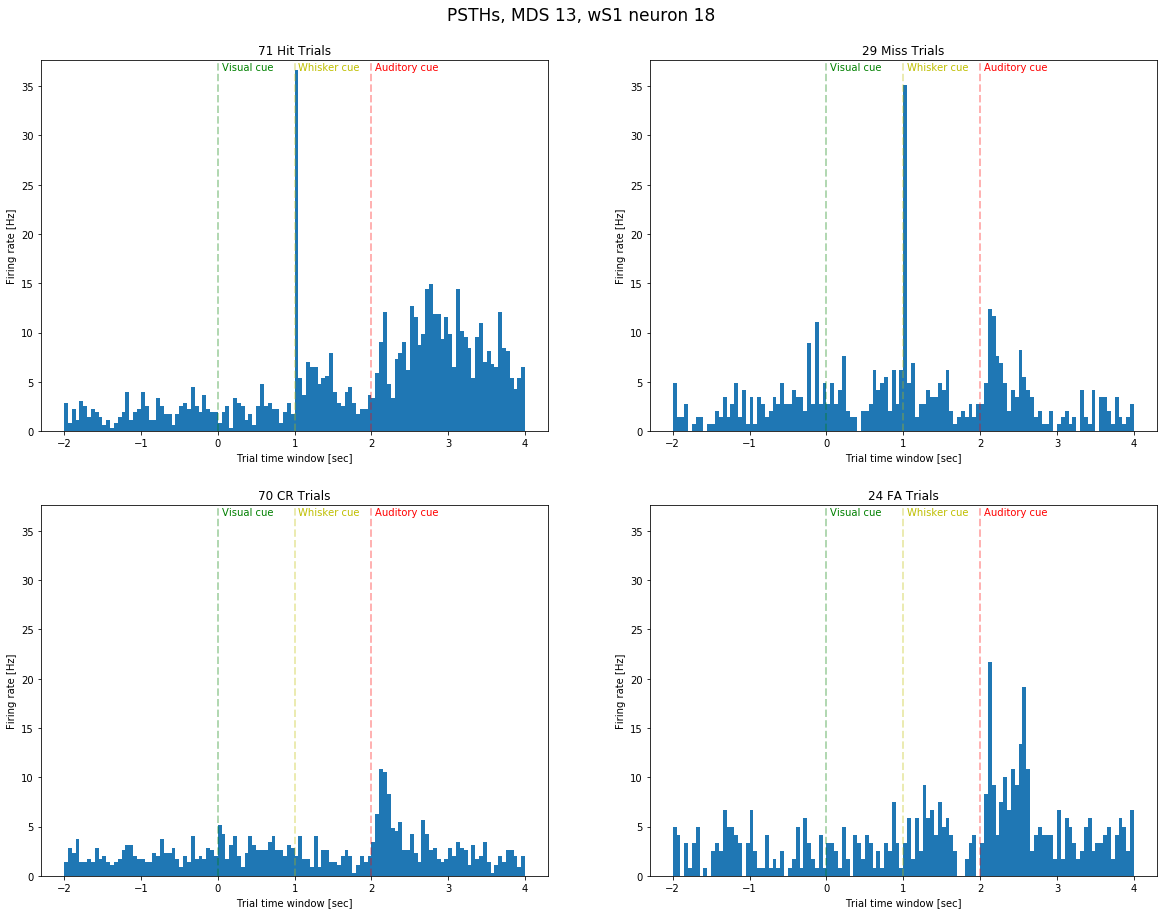

In [20]:
timeBefore = 2.
timeAfter = 4.
binSizePSTH = .05
nBins = int((timeBefore+timeAfter)/binSizePSTH)
neuron = 18 #56 neurons in total (0-55)
neuronType = data['data']['area'][sess][neuron]

CRIndices = data['data']['CRIndices'][sess]
MissIndices = data['data']['MissIndices'][sess]
FAIndices = data['data']['FAIndices'][sess]
HitIndices = data['data']['HitIndices'][sess]

trials = data['data']['TrialOnsets_All'][sess] #for x-th session (194 elements in 0th)

trialsMiss = trials[MissIndices]
trialsHit = trials[HitIndices]
trialsFA = trials[FAIndices]
trialsCR = trials[CRIndices]

spikes = data['data']['spikets'][sess][neuron] #for x-th session & y-th neuron

cueFactor = 1.0
fig, axs = plt.subplots(2,2,figsize=(20,15))

#Psth is averaged across trial types
(averageBins1, stdBins, binCenters) = psthSpikeCount(spikes, trialsHit, timeBefore, timeAfter, binSizePSTH)
(averageBins2, stdBins, binCenters) = psthSpikeCount(spikes, trialsMiss, timeBefore, timeAfter, binSizePSTH)
(averageBins3, stdBins, binCenters) = psthSpikeCount(spikes, trialsCR, timeBefore, timeAfter, binSizePSTH)
(averageBins4, stdBins, binCenters) = psthSpikeCount(spikes, trialsFA, timeBefore, timeAfter, binSizePSTH)
maxBin = np.max(np.concatenate((averageBins1,averageBins2,averageBins3,averageBins4), axis=None)/binSizePSTH)


## Hit Trials
nTrials = len(trialsHit)
#maxBin = np.max(averageBins/binSize)
axs[0, 0].bar(binCenters,averageBins1/binSizePSTH, width = binSizePSTH)
axs[0, 0].set_title(str(nTrials) + ' Hit Trials')
axs[0, 0].set_xlabel('Trial time window [sec]')
axs[0, 0].set_ylabel('Firing rate [Hz]')
axs[0, 0].set_ylim(top=maxBin+1)
#Visual cue/Trial start
axs[0, 0].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
axs[0, 0].text(x = .05, y = cueFactor * maxBin, s = "Visual cue", color = 'green')

#Whisker cue
axs[0, 0].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
axs[0, 0].text(x = 1.05, y = cueFactor * maxBin, s = "Whisker cue", color = 'y')

#Auditory cue
axs[0, 0].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
axs[0, 0].text(x = 2.05, y = cueFactor * maxBin, s = "Auditory cue", color = 'red')


## Miss Trials
nTrials = len(trialsMiss)
#maxBin = np.max(averageBins/binSize)
axs[0, 1].bar(binCenters,averageBins2/binSizePSTH, width = binSizePSTH)
axs[0, 1].set_title(str(nTrials) + ' Miss Trials')
axs[0, 1].set_xlabel('Trial time window [sec]')
axs[0, 1].set_ylabel('Firing rate [Hz]')
axs[0, 1].set_ylim(top=maxBin+1)
#Visual cue/Trial start
axs[0, 1].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
axs[0, 1].text(x = .05, y = cueFactor * maxBin, s = "Visual cue", color = 'green')

#Whisker cue
axs[0, 1].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
axs[0, 1].text(x = 1.05, y = cueFactor * maxBin, s = "Whisker cue", color = 'y')

#Auditory cue
axs[0, 1].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
axs[0, 1].text(x = 2.05, y = cueFactor * maxBin, s = "Auditory cue", color = 'red')


## CR Trials
nTrials = len(trialsCR)
#maxBin = np.max(averageBins/binSize)
axs[1, 0].bar(binCenters,averageBins3/binSizePSTH, width = binSizePSTH)
axs[1, 0].set_title(str(nTrials) + ' CR Trials')
axs[1, 0].set_xlabel('Trial time window [sec]')
axs[1, 0].set_ylabel('Firing rate [Hz]')
axs[1, 0].set_ylim(top=maxBin+1)
#Visual cue/Trial start
axs[1, 0].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
axs[1, 0].text(x = .05, y = cueFactor * maxBin, s = "Visual cue", color = 'green')

#Whisker cue
axs[1, 0].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
axs[1, 0].text(x = 1.05, y = cueFactor * maxBin, s = "Whisker cue", color = 'y')

#Auditory cue
axs[1, 0].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
axs[1, 0].text(x = 2.05, y = cueFactor * maxBin, s = "Auditory cue", color = 'red')



## FA Trials
nTrials = len(trialsFA)
#maxBin = np.max(averageBins/binSize)
axs[1, 1].bar(binCenters,averageBins4/binSizePSTH, width = binSizePSTH)
axs[1, 1].set_title(str(nTrials) + ' FA Trials')
axs[1, 1].set_xlabel('Trial time window [sec]')
axs[1, 1].set_ylabel('Firing rate [Hz]')
axs[1, 1].set_ylim(top=maxBin+1)
#Visual cue/Trial start
axs[1, 1].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
axs[1, 1].text(x = .05, y = cueFactor * maxBin, s = "Visual cue", color = 'green')

#Whisker cue
axs[1, 1].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
axs[1, 1].text(x = 1.05, y = cueFactor * maxBin, s = "Whisker cue", color = 'y')

#Auditory cue
axs[1, 1].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
axs[1, 1].text(x = 2.05, y = cueFactor * maxBin, s = "Auditory cue", color = 'red')

plt.suptitle('PSTHs, MDS ' + str(int(MDS)) + ', '+ neuronType + ' neuron ' + str(neuron),
             fontsize = 17, y = 0.93)
plt.savefig('Figures/3 PSTHs for specific neuron/' + str(int(MDS)) + ' - PSTHs, ' + neuronType + ' neuron ' + str(neuron) + '.jpeg', format = 'jpeg')
plt.show()

## 1.4 Grand-average PSTH

###  Grand-average PSTH functions

In [21]:
def averageNeuronSpikeCount(spikes, trials, timeBefore = 2., timeAfter = 4., binSize = 0.05):
    averageNeuronBins = []
    averageStdBins = []
    averagedBinCenters = []
    for spike in spikes:
        (averageBins, stdBins, binCenters) = psthSpikeCount(spike, trialsHit, timeBefore, timeAfter, binSize)
        averageNeuronBins.append(averageBins)
        averageStdBins.append(stdBins)
        averagedBinCenters = binCenters
        
    averagedNeuronBins = np.mean(averageNeuronBins, axis = 0)
    averagedStdBins = np.mean(averageStdBins, axis = 0)
    #averagedBinCenters = binCenters
     
    #averaged across the neurons for one area
    return (averagedNeuronBins, averagedStdBins, averagedBinCenters)

### Grand-average PSTH plot (Fig. 4)

In [22]:
#This plot takes about 45 sec to compute

[]

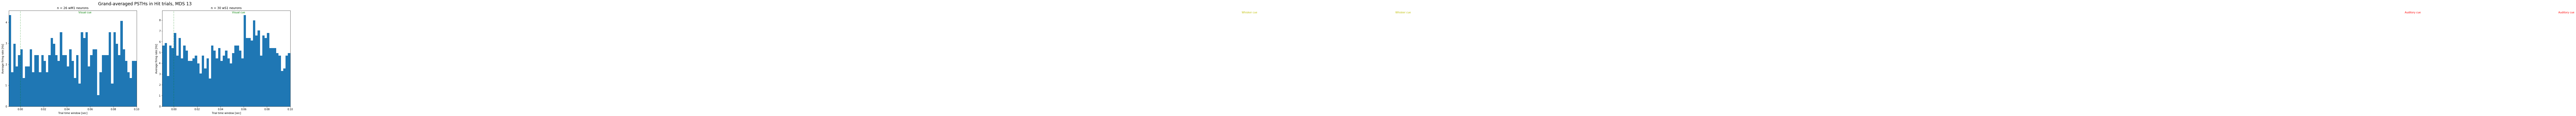

In [85]:
import collections
import random

sess = 0
selectedTrialType = 'Hit'

binSizePSTH = .002
MDS = data['data']['MDS'][sess]
neuronTypes = data['data']['area'][sess]
trials = data['data']['TrialOnsets_All'][sess]

if selectedTrialType == 'Hit':
    HitIndices = data['data']['HitIndices'][sess]    
    chosenTrials = trials[HitIndices]
elif selectedTrialType == 'Miss': 
    MissIndices = data['data']['MissIndices'][sess]    
    chosenTrials = trials[MissIndices]
elif selectedTrialType == 'CR': 
    CRndices = data['data']['CRIndices'][sess]    
    chosenTrials = trials[CRIndices]
elif selectedTrialType == 'FA': 
    FAIndices = data['data']['FAIndices'][sess]    
    chosenTrials = trials[FAIndices]
else:
    #forcefully choose Hit trials
    selectedTrialType = 'Hit'
    HitIndices = data['data']['HitIndices'][sess]    
    chosenTrials = trials[HitIndices]    
nTrials = len(chosenTrials)
    
maskArea = {}
for area in sessAreas[str(MDS)]:
    #print(area)
    maskArea[area] = [True if i == area else False for i in neuronTypes]

spikesArea = {}
for area in sessAreas[str(MDS)]:
    spikesArea[area] = [data['data']['spikets'][sess][i] for i,t in enumerate(maskArea[area]) if t]

nArea = {}
for area in sessAreas[str(MDS)]:
    nArea[area] = collections.Counter(neuronTypes).get(area)

fig, axs = plt.subplots(1,2,figsize=(20,7))

for i,area in enumerate(list(sessAreas[str(MDS)])): 
    #average along all neurons of one area, fixed TT, session
    (averageNeuronBins, stdBins, binCenters) = averageNeuronSpikeCount(spikesArea[area], 
                                                                   chosenTrials, timeBefore = 0.01, 
                                                                   timeAfter = .1, binSize = binSizePSTH)
    
    maxBin = np.max(averageNeuronBins/binSizePSTH)
    axs[i].bar(binCenters,averageNeuronBins/binSizePSTH, width = binSizePSTH)
    axs[i].set_title('n = ' + str(nArea[area]) + ' ' + area + ' neurons')
    axs[i].set_xlabel('Trial time window [sec]')
    axs[i].set_ylabel('Average firing rate [Hz]')
    
    #Visual cue/Trial start
    axs[i].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
    axs[i].text(x = .05, y = 1.02 * maxBin, s = "Visual cue", color = 'green')
    axs[i].set_xlim(-0.01,.1)
    #Whisker cue
    axs[i].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
    axs[i].text(x = 1.05, y = 1.02 * maxBin, s = "Whisker cue", color = 'y')
    
    #Auditory cue
    axs[i].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
    axs[i].text(x = 2.05, y = 1.02 * maxBin, s = "Auditory cue", color = 'red')

    #change title to hit
plt.suptitle('Grand-averaged PSTHs in ' + selectedTrialType + ' trials, MDS ' + str(int(MDS)),
             fontsize = 17, y = 0.95)

plt.savefig('Figures/4 Grand-averaged PSTHs for specific trial type/' + str(int(MDS)) + ' - ' + 'Grand-averaged PSTHs averaged in ' + selectedTrialType + ' trials.jpeg', format = 'jpeg')
plt.plot()

# 2 New data structure for trial-by-trial analysis

## 2.1 Single trial population activity

### Functions & processing

In [24]:
def matrixMaker (session, trialType, neuronTypes, area, timeBefore, timeAfter, binSize):    
    trialTypes = np.array(makeTrialTypesArray(session))
    trials = data['data']['TrialOnsets_All'][session][trialTypes == trialType] #trials from a certain type
    spikes = [x for i,x in enumerate(data['data']['spikets'][session]) if neuronTypes[i] == area] #neurons from area
    nBins = int((timeBefore+timeAfter)/binSize)
    matrix = np.zeros((len(spikes),len(trials),nBins), dtype = np.int8)
    #print(len(trials))
    for i, spike in enumerate(spikes): #neurons
        print(str(i) + '/' + str(len(spikes)))
        for j, trial in enumerate(trials): #specific trial type's onsets
            for k in range(nBins):
                #selecting spikes in bin
                #print('neuron :' + str(i) + '. trial :' + str(j) + '. bin :' + str(k) + '.')
                matrix[i][j][k] = len(spike[np.logical_and(trial - timeBefore + k*binSize <= spike, spike < trial - timeBefore + (k+1)*binSize)])
                #matrix[i][j][k] = len(spikesInCurrentBin)
    return matrix

In [ ]:
#df stored in df_final.p
"""
binSize = .002
timeBefore = 2.
timeAfter = 4.



#for now explicitly defining areas and trials
trialTypesTuple = ('Hit','Miss','CR','FA','EarlyLick')
df = {}
for i in range(len(MDSs)):
    areaDict = {}
    for area in sessAreas[str(MDSs[i])]:
        trialDict = {}
        for trialType in trialTypesTuple:
            neuronTypes = data['data']['area'][i]
            print('session : ', i, 'MDS : ', MDSs[i], '. area : ', area, '. trial : ', trialType, '.')
            trialDict[trialType] = matrixMaker(i, trialType, neuronTypes, area, timeBefore, timeAfter, binSize)
        areaDict[area] = trialDict
    df[str(MDSs[i])] = areaDict  
    
"""

In [ ]:
binSize = .002
timeBefore = 2.
timeAfter = 4.

#for now explicitly defining areas and trials
trialTypesTupleFull = ('Hit','Miss','CR','FA','EarlyLick')
dfNew = {}
for i,MDS in enumerate(MDSs):
    for area in sessAreas[str(MDS)]:
        for trialType in trialTypesTupleFull:
            neuronTypes = data['data']['area'][i]
            print('session : ', i, 'MDS : ', MDSs[i], '. area : ', area, '. trial : ', trialType, '.')
            dfNew[str(MDS),area,trialType] = matrixMaker(i, trialType, neuronTypes, area, timeBefore, timeAfter, binSize)  

In [25]:
import pickle

#pickle.dump(df, open("df_final.p","wb"))

In [26]:
df = pickle.load(open("df_final.p","rb"))

In [27]:
trialTypesTuple = ('Hit','Miss','CR','FA')

In [28]:
matrix = {}
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        matrix[str(MDS),area] = df[str(MDS)][area]

In [29]:
def concatAllTrials (matrix):
    #concatenate area matrix along the trial axis, assuming #neurons & nBins are constant in one session
    #returns one matrix of all trials for specific session & area
    return np.concatenate((matrix['Hit'],matrix['Miss'],matrix['CR'],matrix['FA'],matrix['EarlyLick']), axis = 1)

In [30]:
concatTrials = {}
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        a = matrix[str(MDS),area]
        concatTrials[str(MDS),area] = np.mean(concatAllTrials(a), axis = 0)

### Single trial population activity plot (Fig. 5)

In [31]:
#This plot takes about 10 sec to compute

[]

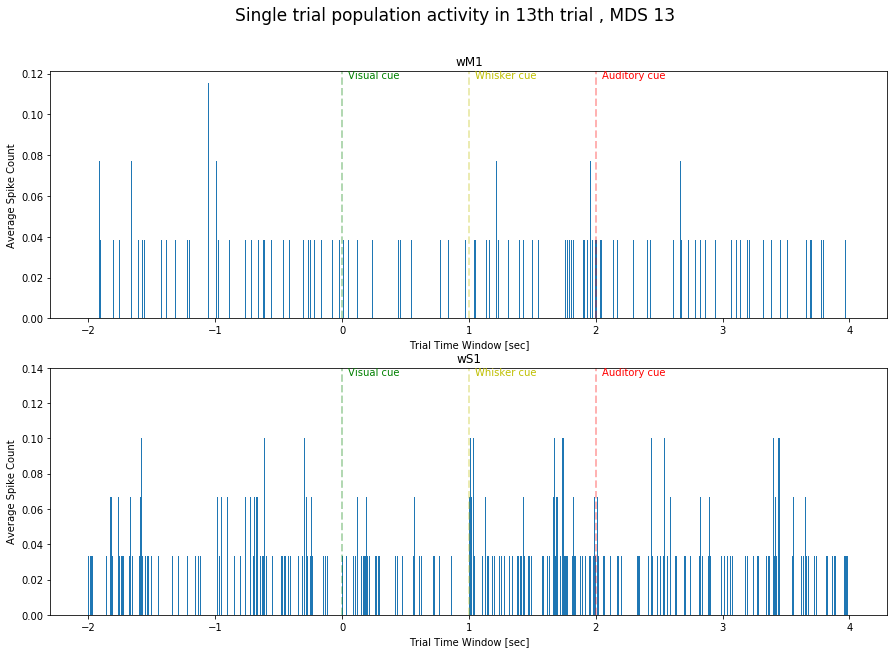

In [32]:
sess = 0
MDS = data['data']['MDS'][sess] 

selTrial = 13

selectedTrial = {}
for area in sessAreas[str(MDS)]:
    selectedTrial[area] = concatTrials[str(MDS),area][selTrial,:]


binSize = .002
timeBefore = 2.
timeAfter = 4.
nBins = int((timeBefore+timeAfter)/binSize)
binCenters = [(bin+.5)*binSize-timeBefore for bin in range(nBins)]

fig, axs = plt.subplots(2,1,figsize=(15,10))
fig.suptitle('Single trial population activity in ' + str(selTrial) + 'th trial , MDS ' + str(int(MDS)),
             fontsize = 17, y = 0.97)

for i,area in enumerate(sessAreas[str(MDS)]):
    maxBin = np.max(selectedTrial[area])
    axs[i].bar(binCenters,selectedTrial[area], width = binSize)
    axs[i].set_title(area)
    axs[i].set_xlabel('Trial Time Window [sec]')
    axs[i].set_ylabel('Average Spike Count')
    #Visual cue/Trial start
    axs[i].axvline(x = 0.,linewidth = 2, color = 'green', linestyle = '--', alpha = 0.3)
    axs[i].text(x = .05, y = 1.02 * maxBin, s = "Visual cue", color = 'green')
    
    #Whisker cue
    axs[i].axvline(x = 1.,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
    axs[i].text(x = 1.05, y = 1.02 * maxBin, s = "Whisker cue", color = 'y')
    
    #Auditory cue
    axs[i].axvline(x = 2.,linewidth = 2, color = 'red', linestyle = '--', alpha = 0.3)
    axs[i].text(x = 2.05, y = 1.02 * maxBin, s = "Auditory cue", color = 'red')
    axs[i].plot()
    
plt.savefig('Figures/5 Single trial population activity in specific trial/' + str(int(MDS)) + ' - ' + 'Single trial population activity in ' + str(selTrial) + 'th trial.jpeg', format = 'jpeg')
plt.plot()

## 2.2 Neuron-averaged spike correlations

### Temporal auto-correlation functions

In [33]:
import scipy.signal as signal

In [34]:
trialTypesTuple = ('Hit','Miss','CR','FA')

#Averaging across the neurons for trial types ->  trials x bins
avg = {}
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        for trial in trialTypesTuple:
            avg[str(MDS),area,trial] = np.mean(df[str(MDS)][area][trial],axis = 0)

In [35]:
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        for trial in trialTypesTuple:
            if np.isnan(avg[str(MDS),area,trial]).any() == True:
                print('NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)

In [36]:
#autocorr dict contains temporal auto-correlation of length 2*nBins-1, for specific trials
autocorr = {}
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        for trial in trialTypesTuple:
            correlate_ = [signal.correlate(x,x) for x in avg[str(MDS),area,trial]]
            if np.isnan(correlate_).any() == True:
                print('NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)
            autocorr[str(MDS),area,trial] = np.mean(correlate_, axis = 0)

### Temporal auto-correlation plot (Fig. 6)

[]

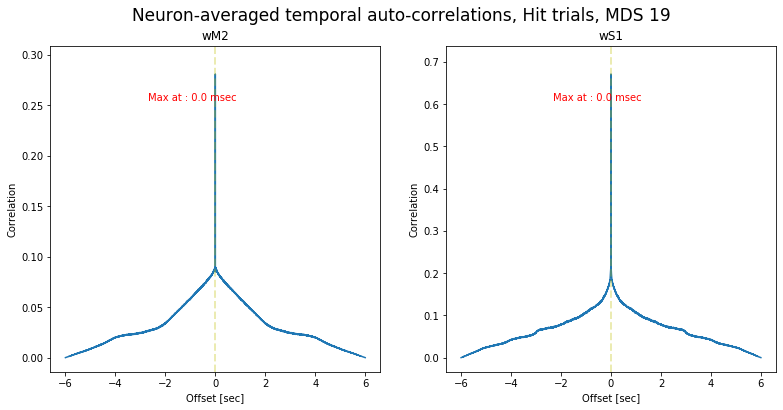

In [37]:
#Selecting session & trial type
sess = 7
MDS = data['data']['MDS'][sess]
trial = 'Hit'

fig, axs = plt.subplots(1,2,figsize=(13,6))
ymax = []
xmax = []
for i,area in enumerate(sessAreas[str(MDSs[sess])]): 
    ymax.append(np.max(autocorr[str(MDS),area,trial]))
    xmax.append(np.argmax(autocorr[str(MDS),area,trial]))
    x = np.linspace(-timeBefore-timeAfter,timeBefore+timeAfter,num=5999,retstep=True)
    axs[i].plot(x[0],autocorr[str(MDS),area,trial])
    axs[i].axvline(x = x[1]*xmax[i]-timeBefore-timeAfter,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
    axs[i].set_title(area)
    axs[i].set_xlabel('Offset [sec]')
    axs[i].set_ylabel('Correlation')
    axs[i].set_ylim(top = 1.1 * np.max(ymax))
    text = "Max at : " + str(x[1]*xmax[i]-timeBefore-timeAfter) + " msec"
    axs[i].text(x = 0.1 + (i*0.55), y = 0.5, s = text, color = 'red',ha='center', va='center', transform=ax.transAxes)
    #plt.savefig('Figures/Auto Correlation of wS1 neurons averaged over Hit Trials.jpeg', format = 'jpeg')
plt.suptitle('Neuron-averaged temporal auto-correlations, ' + trial + ' trials, MDS ' + str(int(MDS)),
             fontsize = 17, y = 0.97)

plt.savefig('Figures/6 Neuron-averaged auto-correlations for specific trial type/' + str(int(MDS)) + ' - ' + 'Neuron-averaged auto-correlations, ' + trial + ' trials.jpeg', format = 'jpeg')
plt.plot()

### Temporal cross-correlation functions

In [38]:
#binCenters comes from nBins, which is fixed to 0.002ms
#defining baseline as 1.5sec before visual cue
baselinebin = np.argwhere(np.array(binCenters) > -1.5)[0][0]

#visual at 0sec
visualbin = np.argwhere(np.array(binCenters) > -0.)[0][0]

#whisker at 1sec
whiskerbin = np.argwhere(np.array(binCenters) > 1.)[0][0]

#auditory at 2sec
auditorybin = np.argwhere(np.array(binCenters) > -2.)[0][0]

In [39]:
#this takes around 20 sec to compute
beforeTimeSmall = 0. #sec
afterTimeSmall = .05 #sec
before = int(beforeTimeSmall/binSize) #in bin
after = int(afterTimeSmall/binSize) #in bin

#timeLag dict contains time lags from area1 -> area2, for fixed MDS & trial type
timeLag = {}

#autocorrHit dict contains temporal auto-correlation of length 2*nBins-1, for hit trials
crosscorr = {}
for MDS in MDSs:
    for trial in trialTypesTuple:
        areas = [x for x in sessAreas[str(MDS)]]
        avg1 = avg[str(MDS),areas[0],trial]
        avg2 = avg[str(MDS),areas[1],trial]
        
        whiskercorr_ = [signal.correlate(x[whiskerbin-before:whiskerbin+after],y[whiskerbin-before:whiskerbin+after]) for x in avg1 for y in avg2]
        if np.isnan(whiskercorr_).any() == True:
                print('whisker : NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)
        crosscorr[str(MDS),trial,'data','whisker cue'] = np.nanmean(whiskercorr_, axis = 0)
        timeLag[str(MDS),trial,'whisker cue'] = (np.argmax(crosscorr[str(MDS),trial,'data','whisker cue'])-((len(crosscorr[str(MDS),trial,'data','whisker cue'])-1)/2))*binSize*1000
        
        baselinecorr_ = [signal.correlate(x[baselinebin-before:baselinebin+after],y[baselinebin-before:baselinebin+after]) for x in avg1 for y in avg2]
        if np.isnan(baselinecorr_).any() == True:
                print('baseline : NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)
        crosscorr[str(MDS),trial,'data','baseline level'] = np.nanmean(baselinecorr_, axis = 0)
        timeLag[str(MDS),trial,'baseline level'] = (np.argmax(crosscorr[str(MDS),trial,'data','baseline level'])-((len(crosscorr[str(MDS),trial,'data','baseline level'])-1)/2))*binSize*1000
        
        visualcorr_ = [signal.correlate(x[visualbin-before:visualbin+after],y[visualbin-before:visualbin+after]) for x in avg1 for y in avg2]
        if np.isnan(visualcorr_).any() == True:
                print('visual : NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)
        crosscorr[str(MDS),trial,'data','visual cue'] = np.nanmean(visualcorr_, axis = 0)
        timeLag[str(MDS),trial,'visual cue'] = (np.argmax(crosscorr[str(MDS),trial,'data','visual cue'])-((len(crosscorr[str(MDS),trial,'data','visual cue'])-1)/2))*binSize*1000
        
        auditorycorr_ = [signal.correlate(x[auditorybin-before:auditorybin+after],y[auditorybin-before:auditorybin+after]) for x in avg1 for y in avg2]
        if np.isnan(auditorycorr_).any() == True:
                print('auditory : NaN in MDS ' + str(MDS) + ', area ' + area + ', trial ' + trial)
        crosscorr[str(MDS),trial,'data','auditory cue'] = np.nanmean(auditorycorr_, axis = 0)
        timeLag[str(MDS),trial,'auditory cue'] = (np.argmax(crosscorr[str(MDS),trial,'data','auditory cue'])-((len(crosscorr[str(MDS),trial,'data','auditory cue'])-1)/2))*binSize*1000
        
        crosscorr[str(MDS),trial,'areas'] = areas

### Temporal cross-correlation at cue plot (Fig. 7)

[]

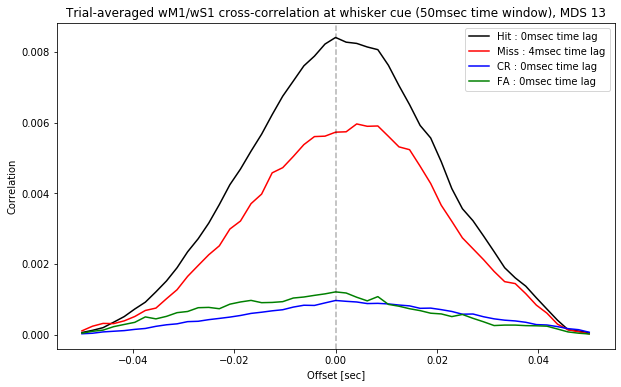

In [81]:
#Selecting session, trial type & cue type
sess = 0
trial = 'CR'
cue = 'whisker cue'

MDS = data['data']['MDS'][sess]
areas = crosscorr[str(MDS),trial,'areas']
timeWindow = afterTimeSmall - beforeTimeSmall

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for trial in trialTypesTuple:
    y = crosscorr[str(MDS),trial,'data',cue]
    x = np.linspace(-beforeTimeSmall-afterTimeSmall,beforeTimeSmall+afterTimeSmall,num=y.shape[0],retstep=True)
    
    #ymax = np.max(y)
    #xmax = np.argmax(y)
    label_ = trial + ' : ' + str(int(timeLag[str(MDS),trial,cue])) + 'msec time lag'
    ax.plot(x[0],y,colorTrials[trial], label = label_)
    #ax.axvline(x = x[1]*xmax-beforeTimeSmall-afterTimeSmall,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
    
    #ax.set_xlim(-0.02,0.02)
    #text = "Max Correlation at : " + str((xmax-((y.shape[0]-1)/2))*binSize) + " sec"
    #ax.text(x = -0.05, y = ymax, s = text, color = 'red')
    #areas[0] + '/' + areas[1] + ' cross-correlation averaged over ' + trial + ' trials at ' + cue + ' (' + str(int(timeWindow*1000)) + 'msec time window)'

ax.axvline(0, color = 'black', linestyle = '--', alpha = 0.3)
ax.set_title('Trial-averaged ' + areas[0] + '/' + areas[1] + ' cross-correlation at ' + cue + ' (' + str(int(timeWindow*1000)) + 'msec time window), MDS ' + str(int(MDS)))
ax.set_xlabel('Offset [sec]')
ax.set_ylabel('Correlation')
plt.legend()
plt.savefig('Figures/7 Trial-averaged cross-correlation at cue/' + str(int(MDS)) + ' - ' + areas[0] + '-' + areas[1] + ' cross-correlation averaged over ' + trial + ' trials at ' + cue + '.jpeg', format = 'jpeg')


plt.plot()

### Averaged temporal cross-correlation functions

In [41]:
#4 subplots for 4 area pairs
#one subplot : 5 lines for each TT, each line is averaged for fixed TT, session list with this particular area pair

In [42]:
cuesTuple = ('baseline level','whisker cue','visual cue','auditory cue')
colorTrials = {'Hit':'black','Miss':'red','CR':'blue','FA':'green'}

In [43]:
crosscorrAvg = {}
for pair in knownPairs:
    MDSs_ = pairMDSs[pair]
    for cue in cuesTuple:
        for trial in trialTypesTuple:
            crosscorrAvg[pair,trial,cue,'mean'] = np.mean([crosscorr[str(MDS_),trial,'data',cue] for MDS_ in MDSs_], axis = 0)
            #print(crosscorrAvg[pair,trial,cue,'mean'].shape)

### Averaged temporal cross-correlation plot (Fig. 8)

[]

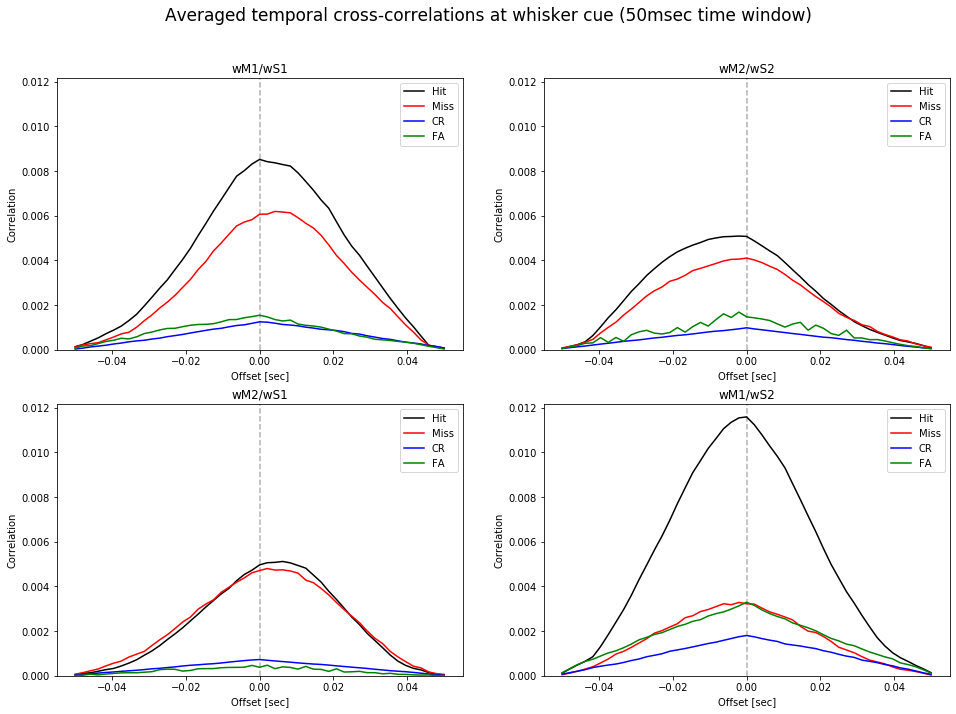

In [44]:
cue = 'whisker cue'

maxylim = []

fig, axs = plt.subplots(2,2,figsize=(16,11))
for i,pair in enumerate(knownPairs):
    axs[i//2,i%2].axvline(0, color = 'black', linestyle = '--', alpha = 0.3)
    for trial in trialTypesTuple:
        y = crosscorrAvg[pair,trial,cue,'mean']
        x = np.linspace(-beforeTimeSmall-afterTimeSmall,beforeTimeSmall+afterTimeSmall,num=y.shape[0],retstep=True)

        #ymax = np.max(y)
        #xmax = np.argmax(y)
        label_ = trial #+ ' : ' + str(int(timeLag[str(MDS),trial,cue])) + 'msec time lag'
        axs[i//2,i%2].plot(x[0],y, colorTrials[trial],label = label_)
        #ax.axvline(x = x[1]*xmax-beforeTimeSmall-afterTimeSmall,linewidth = 2, color = 'y', linestyle = '--', alpha = 0.3)
        
        #ax.set_xlim(-0.02,0.02)
        #text = "Max Correlation at : " + str((xmax-((y.shape[0]-1)/2))*binSize) + " sec"
        #ax.text(x = -0.05, y = ymax, s = text, color = 'red')
        #areas[0] + '/' + areas[1] + ' cross-correlation averaged over ' + trial + ' trials at ' + cue + ' (' + str(int(timeWindow*1000)) + 'msec time window)'
    
        
        axs[i//2,i%2].set_title(pair[0] + '/' + pair[1])
        axs[i//2,i%2].set_xlabel('Offset [sec]')
        axs[i//2,i%2].set_ylabel('Correlation')
        axs[i//2,i%2].legend()
        maxylim.append(axs[i//2,i%2].get_ylim())
        
for i,pair in enumerate(knownPairs):
    for trial in trialTypesTuple:
        axs[i//2,i%2].set_ylim(0,np.max(maxylim))
        
plt.suptitle('Averaged temporal cross-correlations at ' + cue + ' (' + str(int(timeWindow*1000)) + 'msec time window)',
             fontsize = 17, y = 0.97)
plt.savefig('Figures/8 General - Averaged temporal cross-correlations at cue/Averaged temporal cross-correlations at ' + cue + ' (' + str(int(timeWindow*1000)) + 'msec time window).jpeg', format = 'jpeg')


plt.plot()

### Averaged time lags function

In [45]:
# time lags (MDS,TT,cue) : 11 x 5 x 4 values
#for fixed cue : 11 x 5 plot

#average across MDS for particular area pairs -> 4 pairs
#bar plot : fix at whisker cue, 4 big groups (area pairs) : inside 5 bars (mean+ste)

In [72]:
timeLagAvg = {}
for pair in knownPairs:
    MDSs_ = pairMDSs[pair]
    for cue in cuesTuple:
        for trial in trialTypesTuple:
            timeLagAvg[pair,trial,cue,'mean'] = np.mean([timeLag[str(MDS_),trial,cue] for MDS_ in MDSs_])
            timeLagAvg[pair,trial,cue,'std'] = np.std([timeLag[str(MDS_),trial,cue] for MDS_ in MDSs_])
            timeLagAvg[pair,trial,cue,'pair'] = pair

### Averaged time lags plot (Fig. 9)

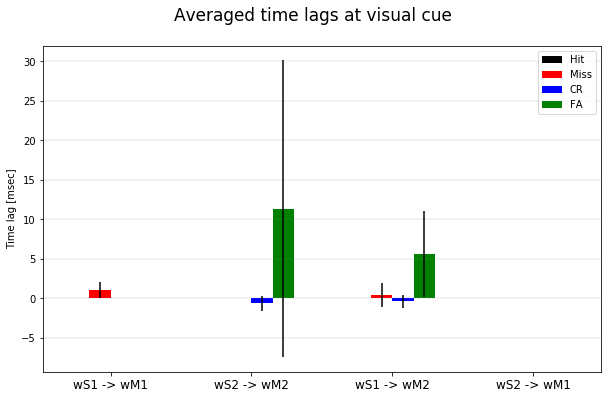

In [82]:
cue = 'visual cue'
labels_ = [pair[1] + ' -> ' + pair[0] for pair in knownPairs]

x = np.arange(4)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(1,1,figsize=(10,6))

rects1 = ax.bar(x - 3*width/2, [-timeLagAvg[x,'Hit',cue,'mean'] for x in knownPairs], width,yerr = [timeLagAvg[x,'Hit',cue,'std'] for x in knownPairs], label='Hit',color='black')
rects2 = ax.bar(x - width/2, [-timeLagAvg[x,'Miss',cue,'mean'] for x in knownPairs], width,yerr = [timeLagAvg[x,'Miss',cue,'std'] for x in knownPairs], label='Miss',color='red')
rects3 = ax.bar(x + width/2, [-timeLagAvg[x,'CR',cue,'mean'] for x in knownPairs], width,yerr = [timeLagAvg[x,'CR',cue,'std'] for x in knownPairs], label='CR',color='blue')
rects4 = ax.bar(x + 3*width/2, [-timeLagAvg[x,'FA',cue,'mean'] for x in knownPairs], width,yerr = [timeLagAvg[x,'FA',cue,'std'] for x in knownPairs], label='FA',color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Time lag [msec]')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels_,fontsize = 12)
ax.legend()

plt.grid(color='gray', linestyle='-', linewidth=2, alpha = .1, axis = 'y')
#fig.tight_layout()
plt.suptitle('Averaged time lags at ' + cue,
             fontsize = 17, y = 0.97)
plt.savefig('Figures/9 General - Averaged time lags at cue/Averaged time lags at ' + cue + '.jpeg', format = 'jpeg')
plt.show()

## 2.3 Pearson correlations

### Processing data at cue

In [48]:
timeAfterCue = .05 #sec
binAfterCue = int(timeAfterCue/binSize) #in bins

In [49]:
cueMat = {}
for MDS in MDSs:
    for area in sessAreas[str(MDS)]:
        for trial in trialTypesTuple:
            cueMat[str(MDS),area,trial,'whisker cue'] = np.sum(df[str(MDS)][area][trial][:,:,whiskerbin:whiskerbin+binAfterCue], axis = 2)
            cueMat[str(MDS),area,trial,'baseline level'] = np.sum(df[str(MDS)][area][trial][:,:,baselinebin:baselinebin+binAfterCue], axis = 2)
            cueMat[str(MDS),area,trial,'auditory cue'] = np.sum(df[str(MDS)][area][trial][:,:,auditorybin:auditorybin+binAfterCue], axis = 2)
            cueMat[str(MDS),area,trial,'visual cue'] = np.sum(df[str(MDS)][area][trial][:,:,visualbin:visualbin+binAfterCue], axis = 2)

### Spike count plot (Fig. 10)

In [50]:
#do not show this figure

[]

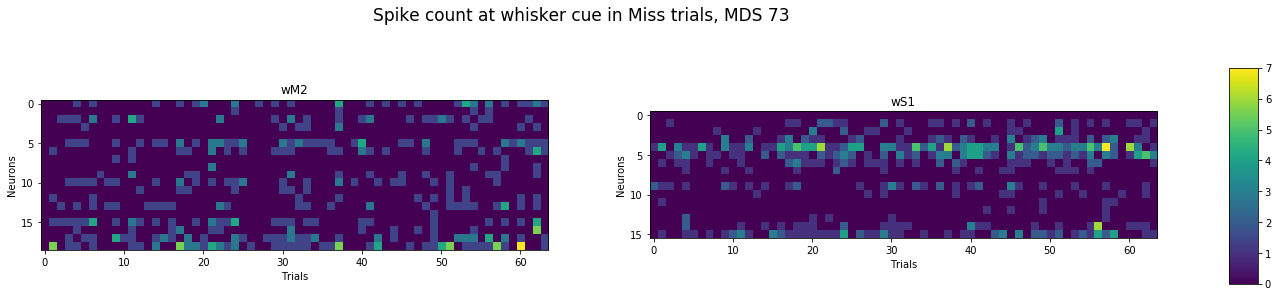

In [51]:
#Selecting session, trial type & cue type
sess = 9
trial = 'Miss'
cue = 'whisker cue'

MDS = data['data']['MDS'][sess]

fig, axs = plt.subplots(1,2,figsize=(20,5))

for i,area in enumerate(sessAreas[str(MDSs[sess])]): 
    _ = axs[i].imshow(cueMat[str(MDS),area,trial,cue])
    #axs[i].set_aspect('equal')
    axs[i].set_xlabel('Trials')
    axs[i].set_ylabel('Neurons')
    axs[i].set_title(area)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
fig.colorbar(_, cax=cbar_ax)
plt.suptitle('Spike count at ' + cue + ' in '+ trial + ' trials, MDS ' + str(int(MDS)),
             fontsize = 17, y = 0.97)
    
plt.savefig('Figures/10 Spike count for specific trial at cue/' + str(int(MDS)) + ' - ' + 'Spike count at ' + cue + ' in '+ trial + ' trials.jpeg', format = 'jpeg')
plt.plot()

### Cleaning neurons that do not fire in all trials

In [75]:
cueMatClean = {}
nNeuronsClean = {}
for MDS in MDSs:   
    for area in sessAreas[str(MDS)]:
        for cue in cuesTuple:
            zeroRows = []
            for trial in trialTypesTuple:
                cue_ = cueMat[str(MDS),area,trial,cue]
                #we delete neurons that fire in all trial types
                for i,row in enumerate(cue_):
                    num_of_non_zeros = np.count_nonzero(row)
                    if num_of_non_zeros == 0:
                         zeroRows.append(i)
            zeroRows = list(set(zeroRows))
            for trial in trialTypesTuple:
                cueMatClean[str(MDS),area,trial,cue] = np.delete(cueMat[str(MDS),area,trial,cue],zeroRows,axis = 0)
                nNeuronsClean[str(MDS),area,trial,cue] = cueMatClean[str(MDS),area,trial,cue].shape[0]
                #print(str(MDS)+ ' ' + trial + ' '+cue + ' ' + area +'. before : ' +str(cueMat[str(MDS),area,trial,cue].shape[0])+ '. after : '+ str(cueMatClean[str(MDS),area,trial,cue].shape[0])+ '. empty neurons : ' + str(len(zeroRows)))

###  Concatenating both areas in one matrix

In [76]:
#Residuals for each MDS,area,trial type, cue type : cueMatClean - mean of each row(mean of spikes across trials) : neurons x trials
cueResids = {}

#concatenated from residuals from both session's areas : neurons_area1+neurons_area2 x trials
cueResidsConcat = {}

#concatenated from both session's areas : neurons_area1+neurons_area2 x trials
cueConcat = {}
for MDS in MDSs:
    for trial in trialTypesTuple:
        for cue in cuesTuple:
            for area in list(sessAreas[str(MDS)]):
                cueResids[str(MDS),area,trial,cue] = cueMatClean[str(MDS),area,trial,cue] - cueMatClean[str(MDS),area,trial,cue].mean(axis = 1, keepdims = True)
            areas = list(sessAreas[str(MDS)])
            cueResidsConcat[str(MDS),trial,cue,'data'] = np.concatenate((cueResids[str(MDS),areas[0],trial,cue],cueResids[str(MDS),areas[1],trial,cue]),axis = 0)
            cueResidsConcat[str(MDS),trial,cue,'areas'] = areas
            cueConcat[str(MDS),trial,cue,'data'] = np.concatenate((cueMatClean[str(MDS),areas[0],trial,cue],cueMatClean[str(MDS),areas[1],trial,cue]),axis = 0)
            cueConcat[str(MDS),trial,cue,'areas'] = areas

### Computing Pearson correlation matrices

In [77]:
from scipy.stats import pearsonr

pearsonMat = {}
print('List of excluded matrices :')
for MDS in MDSs:
    for trial in trialTypesTuple:
        for cue in cuesTuple:
            #Residuals : irrelevant, as collapsed into one bin at cue
            """
            cueResidsConcat_ = cueResidsConcat[str(MDS),trial,cue,'data']
            pearsonMat[str(MDS),trial,cue,'unthresholded','residuals'] = np.zeros((cueResidsConcat_.shape[0],cueResidsConcat_.shape[0]))
            pearsonMat[str(MDS),trial,cue,'thresholded','residuals'] = np.zeros((cueResidsConcat_.shape[0],cueResidsConcat_.shape[0]))
            if all(x > y for x, y in zip(cueResidsConcat_.shape, (2,2))):
                for i,neuron1 in enumerate(cueResidsConcat_):
                    for j, neuron2 in enumerate(cueResidsConcat_):
                        corr, p = pearsonr(cueResidsConcat_[i,:], cueResidsConcat_[j,:])
                        pearsonMat[str(MDS),trial,cue,'unthresholded','residuals'][i][j] = corr
                        if p < .05:
                            pearsonMat[str(MDS),trial,cue,'thresholded','residuals'][i][j] = corr
                        else :
                            pearsonMat[str(MDS),trial,cue,'thresholded','residuals'][i][j] = 0.0
            else:
                print('MDS ' + str(MDS) + ',\t' + trial + ',\t' + cue + ',\tshape : ' + str(cueResidsConcat_.shape))
            """
            #Normal
            cueConcat_ = cueConcat[str(MDS),trial,cue,'data']
            pearsonMat[str(MDS),trial,cue,'unthresholded','normal'] = np.zeros((cueConcat_.shape[0],cueConcat_.shape[0]))
            pearsonMat[str(MDS),trial,cue,'thresholded','normal'] = np.zeros((cueConcat_.shape[0],cueConcat_.shape[0])) 
            if all(x > y for x, y in zip(cueConcat_.shape, (2,2))):
                for i,neuron1 in enumerate(cueConcat_):
                    for j, neuron2 in enumerate(cueConcat_):
                        corr, p = pearsonr(cueConcat_[i,:], cueConcat_[j,:])
                        pearsonMat[str(MDS),trial,cue,'unthresholded','normal'][i][j] = corr
                        if p < .05:
                            pearsonMat[str(MDS),trial,cue,'thresholded','normal'][i][j] = corr
                        else :
                            pearsonMat[str(MDS),trial,cue,'thresholded','normal'][i][j] = 0.0
            else:
                print('MDS ' + str(MDS) + ',\t' + trial + ',\t' + cue + ',\tshape : ' + str(cueConcat_.shape))

List of excluded matrices :
MDS 58.0,	FA,	baseline level,	shape : (10, 1)
MDS 58.0,	FA,	whisker cue,	shape : (8, 1)
MDS 58.0,	FA,	visual cue,	shape : (3, 1)
MDS 58.0,	FA,	auditory cue,	shape : (9, 1)


### Pearson correlation matrices (Fig. 11)

[]

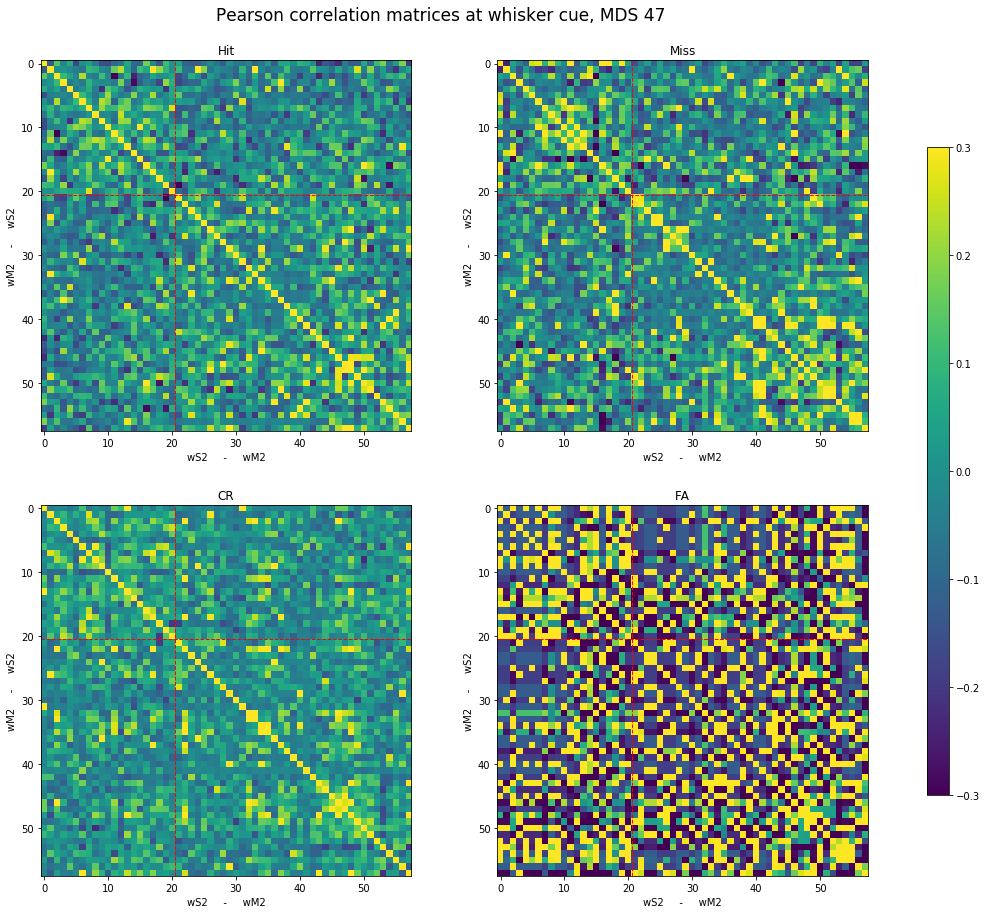

In [80]:
#We don't really care about this figure in an invidiual level

sess = 3
cue = 'whisker cue'

MDS = data['data']['MDS'][sess]

fig, axs = plt.subplots(2,2,figsize=(15,15))

for i,trial in enumerate(trialTypesTuple): 
    _ = axs[i//2,i%2].imshow(pearsonMat[str(MDS),trial,cue,'unthresholded','normal'],vmin = -0.3, vmax = 0.3)
    axs[i//2,i%2].set_xlabel(cueConcat[str(MDS),trial,cue,'areas'][0] + '     -     ' + cueConcat[str(MDS),trial,cue,'areas'][1])
    axs[i//2,i%2].set_ylabel(cueConcat[str(MDS),trial,cue,'areas'][1] + '     -     ' + cueConcat[str(MDS),trial,cue,'areas'][0])
    axs[i//2,i%2].set_aspect('equal')
    axs[i//2,i%2].set_title(trial)
    nNeurons = nNeuronsClean[str(MDS),cueConcat[str(MDS),trial,cue,'areas'][0],trial,cue]
    axs[i//2,i%2].axvline(x = nNeurons - 0.5,linewidth = 1, color = 'red', linestyle = '--', alpha = 1)
    axs[i//2,i%2].axhline(y = nNeurons - 0.5,linewidth = 1, color = 'red', linestyle = '--', alpha = 1)
cbar_ax = fig.add_axes([0.95, 0.2, 0.02, 0.6])
fig.colorbar(_, cax=cbar_ax)
plt.suptitle('Pearson correlation matrices at ' + cue + ', MDS ' + str(int(MDS)),
             fontsize = 17, y = 0.93)
plt.savefig('Figures/11 Pearson correlation matrices at cue/' + str(int(MDS)) + ' - ' + 'Pearson correlation matrices at ' + cue + '.jpeg', format = 'jpeg')

plt.plot()

In [79]:
nNeuronsClean[str(MDS),cueConcat[str(MDS),trial,cue,'areas'][0],trial,cue]

9

### Area-averaged Pearson correlations

In [56]:
def upper_tri_masking(A):
    m = A.shape[0]
    r = np.arange(m)
    mask = r[:,None] < r
    return A[mask]

In [57]:
intcorr = {}
for MDS in MDSs:
    for trial in trialTypesTuple:
        for cue in cuesTuple:
            area_0 = cueConcat[str(MDS),trial,cue,'areas'][0]
            area_1 = cueConcat[str(MDS),trial,cue,'areas'][1]
            nNeurons_0 = nNeuronsClean[str(MDS),area_0,trial,cue]
            nNeurons_1 = nNeuronsClean[str(MDS),area_1,trial,cue]
            mat_ = pearsonMat[str(MDS),trial,cue,'unthresholded','normal']
            mat_0 = mat_[:nNeurons_0,:nNeurons_0]
            mat_1 = mat_[nNeurons_0:,nNeurons_0:]
            mat_2 = mat_[nNeurons_0:,:nNeurons_0]
            intcorr[str(MDS),area_0,trial,cue] = np.nanmean(upper_tri_masking(mat_0))
            intcorr[str(MDS),area_1,trial,cue] = np.nanmean(upper_tri_masking(mat_1))
            intcorr[str(MDS),area_0 + '/' + area_1,trial,cue] = np.nanmean(mat_2)
            if nNeurons_0 == 0:
                intcorr[str(MDS),area_0,trial,cue] = 0.
                intcorr[str(MDS),area_0 + '/' + area_1,trial,cue] = 0.
            if nNeurons_1 == 0:
                intcorr[str(MDS),area_1,trial,cue] = 0.
                intcorr[str(MDS),area_0 + '/' + area_1,trial,cue] = 0.

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


In [58]:
def areaNamer(MDS):
    return([list(sessAreas[str(MDS)])[0],list(sessAreas[str(MDS)])[1],list(sessAreas[str(MDS)])[0] + '/' + list(sessAreas[str(MDS)])[1]])

### Area-averaged Pearson correlations plot (Fig. 12)

[]

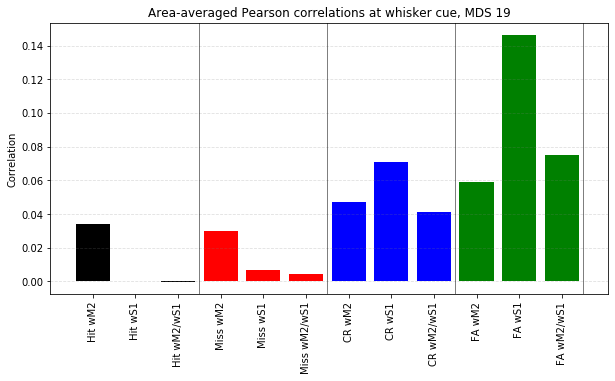

In [59]:
sess = 7
cue = 'whisker cue'

MDS = data['data']['MDS'][sess]

y = []
tags = []
lines_ = [0,0,0,0]
for i,trial in enumerate(trialTypesTuple):
    for name in areaNamer(MDS):
        #print(intcorr[str(MDS),name,trial,cue])
        if intcorr[str(MDS),name,trial,cue] != 0.:
            tags.append(trial + ' ' + name)
            y.append(intcorr[str(MDS),name,trial,cue])
            lines_[i] += 1
fig = plt.figure(figsize=(10, 5))
x = np.arange(len(y))
#print(tags)
ax = fig.add_subplot(111)
ax.set_title('Area-averaged Pearson correlations at ' + cue + ', MDS ' + str(int(MDS)))
ax.set_ylabel('Correlation')
#lines = (2.5,5.5,8.5,11.5)
lines_ = [i for i in lines_ if i != 0]
lines_ = np.cumsum(lines_)
lines_ = [i - .5 for i in lines_]
#print(lines_)
[ax.axvline(_x, linewidth=1, color='black', alpha = .5) for _x in lines_]
ax.yaxis.grid(True, linestyle='--', which='major',
                   color='grey', alpha=.25)
colormap_ = ['black','black','black','red','red','red','blue','blue','blue','green','green','green']
plt.bar(x,y, color = colormap_)
plt.xticks(x, tags,rotation='vertical')
plt.savefig('Figures/12 Area-averaged correlations at cue/' + str(int(MDS)) + ' - Area-averaged Pearson correlations at ' + cue + '.jpeg', format = 'jpeg')

plt.plot()

### Heatmap of area-averaged Pearson correlations (Fig. 13)

In [60]:
import matplotlib
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `plt.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `plt.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `plt.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [61]:
def containsArea(area):
    return ([MDS for MDS in MDSs if area in sessAreas[str(MDS)]])

<string>:6: UserWarning: Warning: converting a masked element to nan.
/opt/anaconda3/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


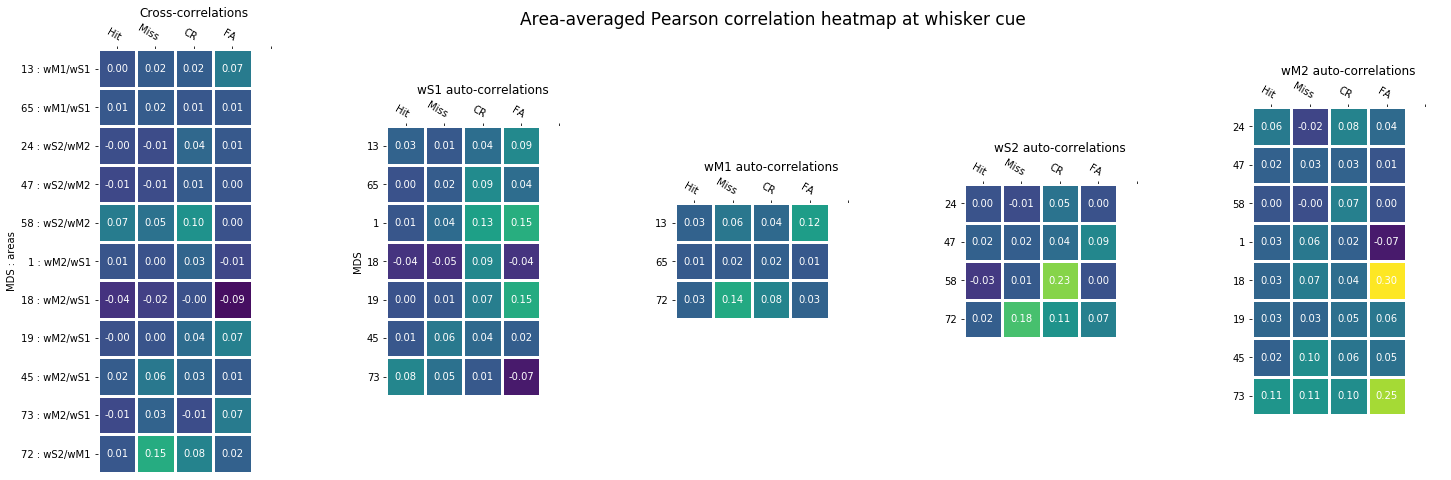

In [62]:
cue = 'whisker cue'
allAreas = ('wS1','wM1','wS2','wM2')
y = np.empty((11,5))
y[:] = np.nan
for i,MDS in enumerate(MDSs):
    for j,trial in enumerate(trialTypesTuple):
            y[i,j] = intcorr[str(MDS),areaNamer(MDS)[2],trial,cue]
            
fig, axs = plt.subplots(1,5,figsize=(25,10))
axs[0].set_title('Cross-correlations')
axs[0].set_ylabel('MDS : areas')

ylabel_ = [str(int(i)) + ' : ' + areaNamer(i)[2] for i in MDSs]
im, cbar = heatmap(y,ylabel_, trialTypesTuple, ax=axs[0],cbar_kw = {'shrink' : .5,'alpha' : 0.},vmin=-.1, vmax=.3)
texts = annotate_heatmap(im, valfmt="{x:.2f}",textcolors=["white", "white"])
cbar.remove()
axs[1].set_ylabel('MDS')
for k,area in enumerate(allAreas):
    MDSarea = containsArea(area)
    y = np.empty((len(MDSarea),5))
    y[:] = np.nan
    for i,MDS in enumerate(MDSarea):
            for j,trial in enumerate(trialTypesTuple):
                y[i,j] = intcorr[str(MDS),area,trial,cue]
    #axs[k+1].set_ylabel('MDS')
    axs[k+1].set_title(area + ' auto-correlations')
    axs[k+1].set_anchor('N')
    im, cbar = heatmap(y,[int(i) for i in MDSarea], trialTypesTuple,
                       ax = axs[k+1], cbar_kw = {'shrink' : .3},vmin=-.1, vmax=.3)
    texts = annotate_heatmap(im, valfmt="{x:.2f}",textcolors=["white", "white"])
    cbar.remove()
    
plt.suptitle('Area-averaged Pearson correlation heatmap at ' + cue,
             fontsize = 17, y = 0.85)
plt.savefig('Figures/13 General - Area-averaged correlation heatmap at cue/Area-averaged Pearson correlation heatmap at ' + cue + '.jpeg', format = 'jpeg')

plt.show()

In [63]:
#dont show this fig ^^^^^

### Grand-averaged auto-correlation barplot (Fig. 14)

In [64]:
# average auto-corr, whisker cue only,avg-std
#big group : area, into this : 5 TT

In [65]:
autocorrAvg = {}
for area in allAreas:
    MDSs_ = areaLooker(area)
    for cue in cuesTuple:
        for trial in trialTypesTuple:
            autocorrAvg[area,trial,cue,'mean'] = np.mean([intcorr[str(MDS_),area,trial,cue] for MDS_ in MDSs_])
            autocorrAvg[area,trial,cue,'std'] = np.std([intcorr[str(MDS_),area,trial,cue] for MDS_ in MDSs_])

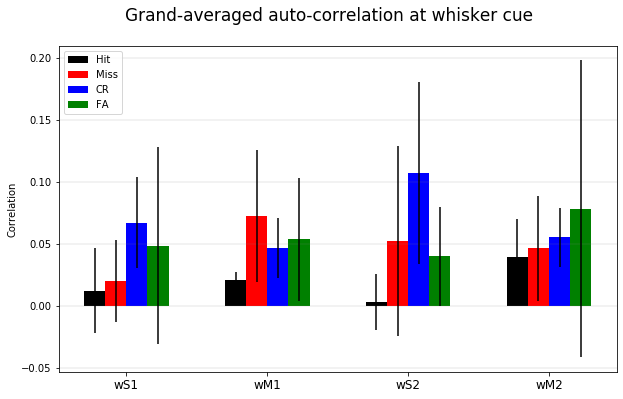

In [66]:
cue = 'whisker cue'
labels_ = [area for area in allAreas]

x = np.arange(4)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(1,1,figsize=(10,6))

rects1 = ax.bar(x - 3*width/2, [autocorrAvg[area,'Hit',cue,'mean'] for area in allAreas], width,yerr = [autocorrAvg[area,'Hit',cue,'std'] for area in allAreas], label='Hit',color='black')
rects2 = ax.bar(x - width/2, [autocorrAvg[area,'Miss',cue,'mean'] for area in allAreas], width,yerr = [autocorrAvg[area,'Miss',cue,'std'] for area in allAreas], label='Miss',color='red')
rects3 = ax.bar(x + width/2, [autocorrAvg[area,'CR',cue,'mean'] for area in allAreas], width,yerr = [autocorrAvg[area,'CR',cue,'std'] for area in allAreas], label='CR',color='blue')
rects4 = ax.bar(x + 3*width/2, [autocorrAvg[area,'FA',cue,'mean'] for area in allAreas], width,yerr = [autocorrAvg[area,'FA',cue,'std'] for area in allAreas], label='FA',color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels_,fontsize = 12)
ax.legend(loc = 'upper left')

plt.grid(color='gray', linestyle='-', linewidth=2, alpha = .1, axis = 'y')
#fig.tight_layout()
plt.suptitle('Grand-averaged auto-correlation at ' + cue,
             fontsize = 17, y = 0.97)
plt.savefig('Figures/14 General - Grand-averaged auto-correlation at cue/Grand-averaged auto-correlation at ' + cue + '.jpeg', format = 'jpeg')
plt.show()

### Grand-averaged cross-correlation barplot (Fig. 15)

In [67]:
# average the cross-correlation of similar pairs, whisker cue only, avg + std
#auto-correlation subplot for each

In [68]:
crosscorrAvg = {}
for pair in knownPairs:
    MDSs_ = pairMDSs[pair]
    for cue in cuesTuple:
        for trial in trialTypesTuple:
            crosscorrAvg[pair,trial,cue,'mean'] = np.mean([intcorr[str(MDS_),areaNamer(MDS_)[2],trial,cue] for MDS_ in MDSs_])
            crosscorrAvg[pair,trial,cue,'std'] = np.std([intcorr[str(MDS_),areaNamer(MDS_)[2],trial,cue] for MDS_ in MDSs_])
            crosscorrAvg[pair,trial,cue,'pair'] = pair

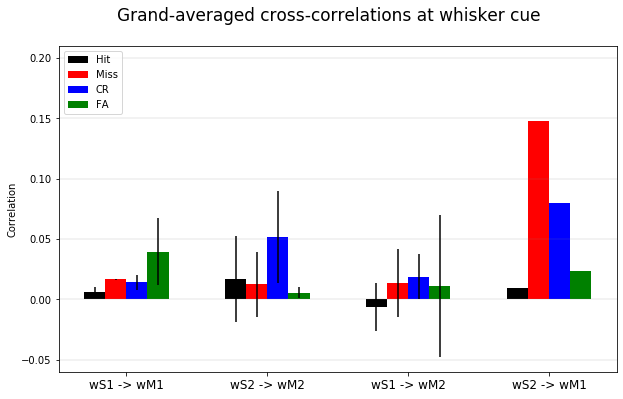

In [69]:
cue = 'whisker cue'
labels_ = [pair[1] + ' -> ' + pair[0] for pair in knownPairs]

x = np.arange(4)  # the label locations
width = 0.15  # the width of the bars

fig, ax = plt.subplots(1,1,figsize=(10,6))

rects1 = ax.bar(x - 3*width/2, [crosscorrAvg[x,'Hit',cue,'mean'] for x in knownPairs], width,yerr = [crosscorrAvg[x,'Hit',cue,'std'] for x in knownPairs], label='Hit',color='black')
rects2 = ax.bar(x - width/2, [crosscorrAvg[x,'Miss',cue,'mean'] for x in knownPairs], width,yerr = [crosscorrAvg[x,'Miss',cue,'std'] for x in knownPairs], label='Miss',color='red')
rects3 = ax.bar(x + width/2, [crosscorrAvg[x,'CR',cue,'mean'] for x in knownPairs], width,yerr = [crosscorrAvg[x,'CR',cue,'std'] for x in knownPairs], label='CR',color='blue')
rects4 = ax.bar(x + 3*width/2, [crosscorrAvg[x,'FA',cue,'mean'] for x in knownPairs], width,yerr = [crosscorrAvg[x,'FA',cue,'std'] for x in knownPairs], label='FA',color='green')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Correlation')
#ax.set_title('Scores by group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels_,fontsize = 12)
ax.legend(loc = 'upper left')
ax.set_ylim(-0.06,0.21)

plt.grid(color='gray', linestyle='-', linewidth=2, alpha = .1, axis = 'y')
#fig.tight_layout()
plt.suptitle('Grand-averaged cross-correlations at ' + cue,
             fontsize = 17, y = 0.97)
plt.savefig('Figures/15 General - Grand-averaged cross-correlations at cue/Grand-averaged cross-correlations at ' + cue + '.jpeg', format = 'jpeg')
plt.show()

### Grand-averaged correlation heatmap (Fig. 16)

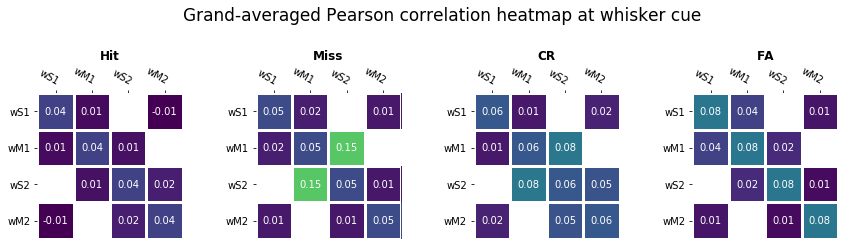

In [70]:
cue = 'whisker cue'

fig, axs = plt.subplots(1,4,figsize=(15,15))
labels_ = [area for area in allAreas]

for z,trial in enumerate(trialTypesTuple):
    y = np.empty((4,4))
    y[:] = np.nan
    for i,area1 in enumerate(allAreas):
        for j,area2 in enumerate(allAreas):
            if i == j:
                y[i,j] = autocorrAvg[area,trial,cue,'mean']
            else:    
                key_ = ((area1,area2),trial,cue,'mean')
                y[i,j] = crosscorrAvg.get(key_, np.nan)
                if y[i,j] == np.nan:  
                    key_ = ((area2,area1),trial,cue,'mean') 
                    y[i,j] = crosscorrAvg.get(key_, np.nan)
    
    y[2,1] = y[1,2]
    y[1,2] = np.nan
    
    for i in range(4):
        for j in range(4):
            if i < j:
                y[i,j] = y[j,i]
    axs[z].set_title(trial, weight = 'bold')
    axs[z].set_anchor('N')
    im, cbar = heatmap(y,labels_, labels_, ax = axs[z], cbar_kw = {'shrink' : .3},vmin=0., vmax=.2)
    texts = annotate_heatmap(im, valfmt="{x:.2f}",textcolors=["white", "white"])
    cbar.remove()
     
plt.suptitle('Grand-averaged Pearson correlation heatmap at ' + cue,
             fontsize = 17, y = 0.65)
plt.savefig('Figures/16 General - Grand-averaged correlation heatmap at cue/Grand-averaged Pearson correlation heatmap at ' + cue + '.jpeg', format = 'jpeg')

plt.show()